In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
image = cv2.imread('images_for_editing/DSC02988.JPG')
image_mem = cv2.imread('images_for_editing/mem.jpg')

### Методы геометрического преобразования

In [3]:
def show_img(name, img):
    cv2.namedWindow(name, cv2.WINDOW_NORMAL) 
    cv2.resizeWindow(name, 1000, 800) 
    cv2.imshow(name, img)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()

In [5]:
show_img('Original', image)

In [6]:
# Сдвиг
tx = -500  
ty = 30  

image_size = (image.shape[1], image.shape[0])

mat_mov = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)
shifted_image = cv2.warpAffine(image, mat_mov, image_size)

show_img('Shifted Image', shifted_image)

In [7]:
# Поворот
center = (image_size[1] //2, image_size[0] //2)

angle = -5
scale = 1

mat_rot = cv2.getRotationMatrix2D(center, angle, scale)  

rotated_image = cv2.warpAffine(image, mat_rot, image_size)
show_img('Rotated image', rotated_image)

In [8]:
# Изменения масштаба
sx = 2
sy = 0.8

mat_sc = np.array([[sx, 0, 0], [0, sy, 0]], dtype=np.float32)

scaled_image = cv2.warpAffine(image_mem, mat_sc, (int(image_mem.shape[1] * sx), int(image_mem.shape[0] * sy)))
show_img('Scaled image', scaled_image)

In [9]:
# Отражение
w, h = image_mem.shape[1], image_mem.shape[0]

mat_flip = np.array([[-1, 0, w], [0, -1, h]], dtype=np.float32)

flipped_image = cv2.warpAffine(image_mem, mat_flip, (w, h))
show_img('Flipped image', flipped_image)

In [10]:
# Проективные преобразование
points1 = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
# points2 = np.array([[0, 100], [w, 100], [w, h - 100], [0, h - 100]], dtype=np.float32)
points2 = np.array([[-100, -100], [w, 0], [w, h], [-100, h+100]], dtype=np.float32)

mat_per = cv2.getPerspectiveTransform(points1, points2)

image_per = cv2.warpPerspective(image_mem, mat_per, (w, h))
show_img('img', image_per)

### Изменение яркости и контраста

In [11]:
image = cv2.imread('images_for_editing/DSC02990.JPG')

In [12]:
show_img('Original', image)

In [13]:
# Яркость и контраст
brighter_image = cv2.convertScaleAbs(image, alpha=2, beta=10)  # beta — яркость, alpha - контраст
show_img('Brighter_image', brighter_image)

### Обработка разными методами фильтрации

In [14]:
image_for_noises = cv2.imread('images_for_editing/DSC02988.JPG')
show_img('Noise_image', image_for_noises)

#### Сгенерируем разные виды шумов

In [15]:
row, col, ch = image_for_noises.shape

In [16]:
# Гауссовский
mean = 0
sigma = 10
gauss = np.random.normal(mean, sigma, (row, col, ch))

image_gaus = np.clip(image_for_noises + gauss, 0, 255).astype(np.uint8)
show_img('Gaussian noise', image_gaus)
cv2.imwrite('images_for_editing/gaussian_noise.jpg', image_gaus)

True

In [17]:
# Соль
salt_prob = 0.01
image_salt = image_for_noises.copy()
num_salt = np.ceil(salt_prob * image_for_noises.size)

coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_for_noises.shape]
image_salt[coords[0], coords[1], :] = 100

show_img('Salt noisy', image_salt)
cv2.imwrite('images_for_editing/salt_noise.jpg', image_salt)

True

In [18]:
# Перец
image_pep = image_for_noises.copy()

image_pep[coords[0], coords[1], :] = 0

show_img('Pepper noisy', image_pep)
cv2.imwrite('images_for_editing/image_pep.jpg', image_pep)

True

In [19]:
# Цветной шум (реальный)
show_img('Noisy image', image)

# или
image_color_noisy = image_for_noises.copy()
num_noise = np.ceil(salt_prob * image_for_noises.size)

coords = [np.random.randint(0, i - 1, int(num_noise)) for i in image_for_noises.shape]

image_color_noisy[coords[0], coords[1], :] = np.random.randint(50, 150, (len(coords[0]), 3))
show_img('Color noise', image_color_noisy)
cv2.imwrite('images_for_editing/image_color_noisy.jpg', image_color_noisy)

True

#### Обработка различными методами

In [20]:
img_gaus = cv2.imread('images_for_editing/gaussian_noise.jpg')
img_color_noisy_gen = cv2.imread('images_for_editing/image_color_noisy.jpg')
img_pep = cv2.imread('images_for_editing/image_pep.jpg')
img_salt = cv2.imread('images_for_editing/salt_noise.jpg')
img_color_noisy_orig = cv2.imread('images_for_editing/DSC02990.JPG')

In [21]:
def psnr_check(orig_img, fil_img):
    original_image = img_as_float(orig_img)
    filtered_image = img_as_float(fil_img)
    psnr_value = psnr(original_image, filtered_image)
    print(f"PSNR: {psnr_value}")

In [22]:
# Медианный фильтр
median_gaus = cv2.medianBlur(img_gaus, 3) 
median_color_noisy_gen = cv2.medianBlur(img_color_noisy_gen, 3) 
median_pep = cv2.medianBlur(img_pep, 3) 
median_salt = cv2.medianBlur(img_salt, 3) 
median_color_noisy_orig = cv2.medianBlur(img_color_noisy_orig, 9)

show_img('median_gaus', median_gaus)
show_img('median_color_noisy_gen', median_color_noisy_gen)
show_img('median_pep', median_pep)
show_img('median_salt', median_salt)
show_img('median_color_noisy_orig', median_color_noisy_orig)


psnr_check(img_gaus, median_gaus)
psnr_check(img_color_noisy_gen, median_color_noisy_gen)
psnr_check(img_pep, median_pep)
psnr_check(img_salt, median_salt)
psnr_check(img_color_noisy_orig, median_color_noisy_orig)

PSNR: 31.953775431053202
PSNR: 26.534381782675432
PSNR: 25.72397830013263
PSNR: 26.838581628397673
PSNR: 29.564084950970702


In [23]:
# Гауссовский фильтр
gaus_gaus = cv2.GaussianBlur(img_gaus, (5, 5), 1.5)
gaus_color_noisy_gen = cv2.GaussianBlur(img_color_noisy_gen, (5, 5), 1.5)
gaus_pep = cv2.GaussianBlur(img_pep, (5, 5), 1.5)
gaus_salt = cv2.GaussianBlur(img_salt, (5, 5), 1.5)
gaus_color_noisy_orig = cv2.GaussianBlur(img_color_noisy_orig, (9, 9), 1.5)

show_img('gaus_gaus', gaus_gaus)
show_img('gaus_color_noisy_gen', gaus_color_noisy_gen)
show_img('gaus_pep', gaus_pep)
show_img('gaus_salt', gaus_salt)
show_img('gaus_color_noisy_orig', gaus_color_noisy_orig)

psnr_check(img_gaus, gaus_gaus)
psnr_check(img_color_noisy_gen, gaus_color_noisy_gen)
psnr_check(img_pep, gaus_pep)
psnr_check(img_salt, gaus_salt)
psnr_check(img_color_noisy_orig, gaus_color_noisy_orig)

PSNR: 32.075188251869534
PSNR: 27.11409161344156
PSNR: 26.31431775497383
PSNR: 27.426416872758438
PSNR: 31.033801048587048


In [24]:
# Билатеральный фильтр
bilat_gaus = cv2.bilateralFilter(img_gaus, 9, 75, 75)
bilat_color_noisy_gen = cv2.bilateralFilter(img_color_noisy_gen, 9, 75, 75)
bilat_pep = cv2.bilateralFilter(img_pep, 9, 75, 75)
bilat_salt = cv2.bilateralFilter(img_salt, 9, 75, 75)
bilat_color_noisy_orig = cv2.bilateralFilter(img_color_noisy_orig, 9, 100, 100)

show_img('bilat_gaus', bilat_gaus)
show_img('bilat_color_noisy_gen', bilat_color_noisy_gen)
show_img('bilat_pep', bilat_pep)
show_img('bilat_salt', bilat_salt)
show_img('bilat_color_noisy_orig', bilat_color_noisy_orig)

psnr_check(img_gaus, bilat_gaus)
psnr_check(img_color_noisy_gen, bilat_color_noisy_gen)
psnr_check(img_pep, bilat_pep)
psnr_check(img_salt, bilat_salt)
psnr_check(img_color_noisy_orig, bilat_color_noisy_orig)

PSNR: 31.997497234135295
PSNR: 34.609963758449034
PSNR: 35.26949493288929
PSNR: 34.97663172803368
PSNR: 30.560798205029723


Билатеральный фильтр хорошо справляется с мягкими переходами, но шумы с резкими контрастными изменениями часто требуют других методов фильтрации

### Получение контурных изображений

In [25]:
image = cv2.imread('images_for_editing/frame_484.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.convertScaleAbs(image, alpha=1.7, beta=-40)
show_img('Gray scale', image)

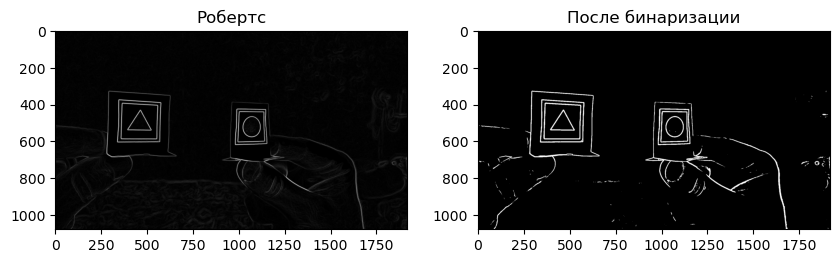

In [6]:
# Робертс
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.5)

def roberts_edge(image):
    kernel_x = np.array([[1, 0], [0, -1]])
    kernel_y = np.array([[0, 1], [-1, 0]])
    
    roberts_x = cv2.filter2D(image, cv2.CV_64F, kernel_x)  # Приведение к CV_64F
    roberts_y = cv2.filter2D(image, cv2.CV_64F, kernel_y)  # Приведение к CV_64F
    
    return cv2.magnitude(roberts_x, roberts_y)

roberts_gradient = roberts_edge(blurred_image)

normalized = cv2.normalize(roberts_gradient, None, 0, 255, cv2.NORM_MINMAX)

_, thresholded_image_roberts = cv2.threshold(normalized, 30, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1), plt.imshow(normalized, cmap='gray'), plt.title('Робертс')
plt.subplot(1, 2, 2), plt.imshow(thresholded_image_roberts, cmap='gray'), plt.title('После бинаризации')
plt.show()

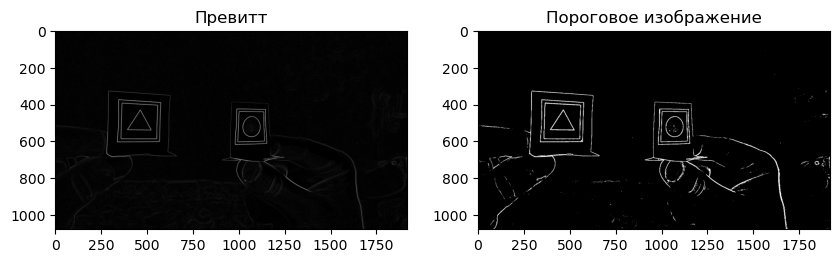

In [75]:
# Превит
kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]) 
kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]) 

edges_prewitt_x = cv2.filter2D(image, cv2.CV_64F, kernel_x)
edges_prewitt_y = cv2.filter2D(image, cv2.CV_64F, kernel_y)

edges_prewitt = cv2.magnitude(edges_prewitt_x, edges_prewitt_y)

normalized = cv2.normalize(edges_prewitt, None, 0, 255, cv2.NORM_MINMAX)

_, thresholded_image = cv2.threshold(normalized, 20, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1), plt.imshow(normalized, cmap='gray'), plt.title('Превитт')
plt.subplot(1, 2, 2), plt.imshow(thresholded_image, cmap='gray'), plt.title('После бинаризации')
plt.show()

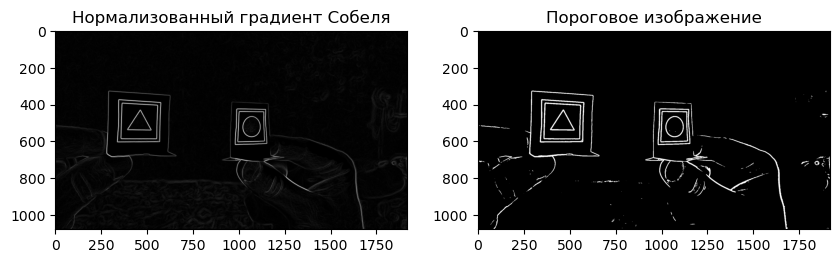

In [76]:
# Собел
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=9) 
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=9) 

sobel_gradient = cv2.magnitude(sobel_x, sobel_y)

sobel_gradient_normalized = cv2.normalize(sobel_gradient, None, 0, 255, cv2.NORM_MINMAX)

_, thresholded_image = cv2.threshold(sobel_gradient_normalized, 30, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1), plt.imshow(sobel_gradient_normalized, cmap='gray'), plt.title('Собел')
plt.subplot(1, 2, 2), plt.imshow(thresholded_image, cmap='gray'), plt.title('После бинаризации')
plt.show()

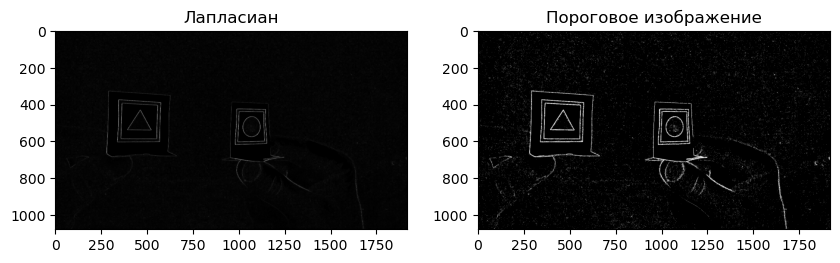

In [87]:
laplacian = cv2.Laplacian(image, cv2.CV_64F)

laplacian_abs = np.uint8(np.absolute(laplacian))

laplacian_normalized = cv2.normalize(laplacian_abs, None, 0, 255, cv2.NORM_MINMAX)

_, thresholded_image = cv2.threshold(laplacian_normalized, 17, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1), plt.imshow(laplacian_normalized, cmap='gray'), plt.title('Лапласиан')
plt.subplot(1, 2, 2), plt.imshow(thresholded_image, cmap='gray'), plt.title('Пороговое изображение')
plt.show()

### Исследование детекторов и дескрипторов

#### Детекторы и вывод ключевых точек

In [41]:
# Функция обработки изображения
def draw_contours(image, treshold=25):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 3)
    
    roberts_gradient = roberts_edge(blurred_image)
    
    normalized = cv2.normalize(roberts_gradient, None, 0, 255, cv2.NORM_MINMAX)
    
    _, thresholded_image_roberts = cv2.threshold(normalized, treshold, 255, cv2.THRESH_BINARY)
    
    # plt.figure(figsize=(6, 3))
    # plt.imshow(thresholded_image_roberts, cmap='gray')
    # plt.show()
    return thresholded_image_roberts

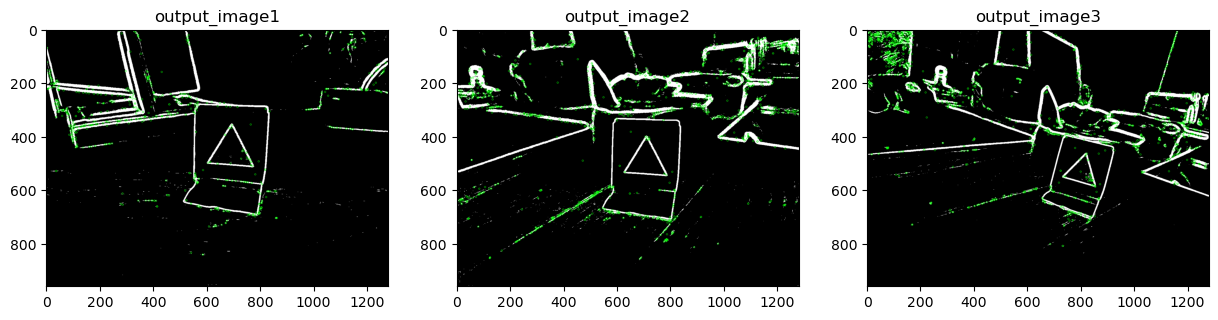

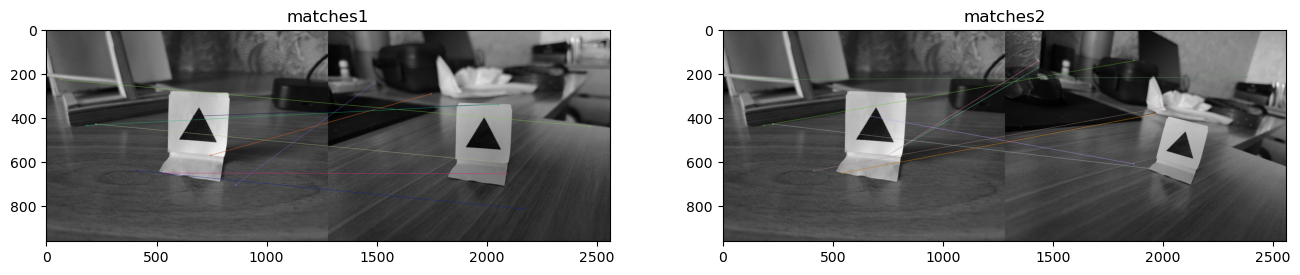

In [42]:
# SIFT
sift = cv2.SIFT_create()

image1 = cv2.imread("images_for_editing/image1.jpg", cv2.IMREAD_GRAYSCALE) 
image2 = cv2.imread("images_for_editing/image2.jpg", cv2.IMREAD_GRAYSCALE)  
image3 = cv2.imread("images_for_editing/image3.jpg", cv2.IMREAD_GRAYSCALE)  

image_roberts_1 = draw_contours(image1, 25)
image_roberts_2 = draw_contours(image2, 25)
image_roberts_3 = draw_contours(image3, 25)

image_roberts_1_8u = np.uint8(image_roberts_1)
image_roberts_2_8u = np.uint8(image_roberts_2)
image_roberts_3_8u = np.uint8(image_roberts_3)

keypoints1, descriptors1 = sift.detectAndCompute(image_roberts_1_8u, None)
keypoints2, descriptors2 = sift.detectAndCompute(image_roberts_2_8u, None)
keypoints3, descriptors3 = sift.detectAndCompute(image_roberts_3_8u, None)

output_image1 = cv2.drawKeypoints(image_roberts_1_8u, keypoints1, None, color=(0, 255, 0))
output_image2 = cv2.drawKeypoints(image_roberts_2_8u, keypoints2, None, color=(0, 255, 0))
output_image3 = cv2.drawKeypoints(image_roberts_3_8u, keypoints3, None, color=(0, 255, 0))

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1), plt.imshow(output_image1), plt.title('output_image1')
plt.subplot(1, 3, 2), plt.imshow(output_image2), plt.title('output_image2')
plt.subplot(1, 3, 3), plt.imshow(output_image3), plt.title('output_image3')
plt.show()
# show_img('SIFT Keypoints', output_image)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(descriptors1, descriptors2)
matches2 = bf.match(descriptors1, descriptors3)

matches = sorted(matches, key=lambda x: x.distance)
matches2 = sorted(matches2, key=lambda x: x.distance)

result_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
result_image2 = cv2.drawMatches(image1, keypoints1, image3, keypoints3, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1), plt.imshow(result_image), plt.title('matches1')
plt.subplot(1, 2, 2), plt.imshow(result_image2), plt.title('matches2')
plt.show()


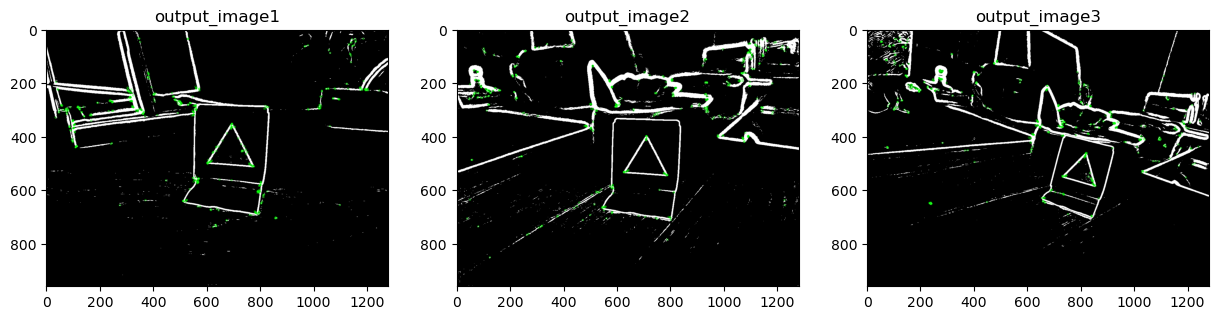

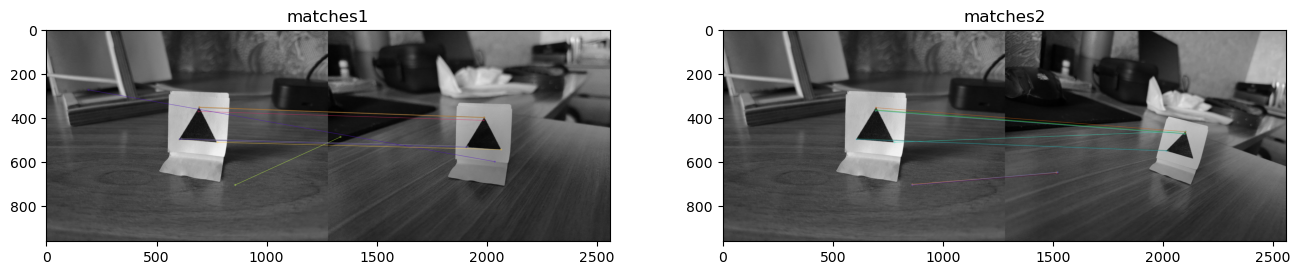

In [46]:
# ORB
orb = cv2.ORB_create(nfeatures=500)  # nfeatures задает количество ключевых точек

keypoints1, descriptors1 = orb.detectAndCompute(image_roberts_1_8u, None)
keypoints2, descriptors2 = orb.detectAndCompute(image_roberts_2_8u, None)
keypoints3, descriptors3 = orb.detectAndCompute(image_roberts_3_8u, None)

output_image1 = cv2.drawKeypoints(image_roberts_1_8u, keypoints1, None, color=(0, 255, 0))
output_image2 = cv2.drawKeypoints(image_roberts_2_8u, keypoints2, None, color=(0, 255, 0))
output_image3 = cv2.drawKeypoints(image_roberts_3_8u, keypoints3, None, color=(0, 255, 0))

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1), plt.imshow(output_image1), plt.title('output_image1')
plt.subplot(1, 3, 2), plt.imshow(output_image2), plt.title('output_image2')
plt.subplot(1, 3, 3), plt.imshow(output_image3), plt.title('output_image3')
plt.show()

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  # NORM_HAMMING для ORB

matches = bf.match(descriptors1, descriptors2)
matches2 = bf.match(descriptors1, descriptors3)

matches = sorted(matches, key=lambda x: x.distance)
matches2 = sorted(matches2, key=lambda x: x.distance)

result_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
result_image2 = cv2.drawMatches(image1, keypoints1, image3, keypoints3, matches2[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1), plt.imshow(result_image), plt.title('matches1')
plt.subplot(1, 2, 2), plt.imshow(result_image2), plt.title('matches2')
plt.show()


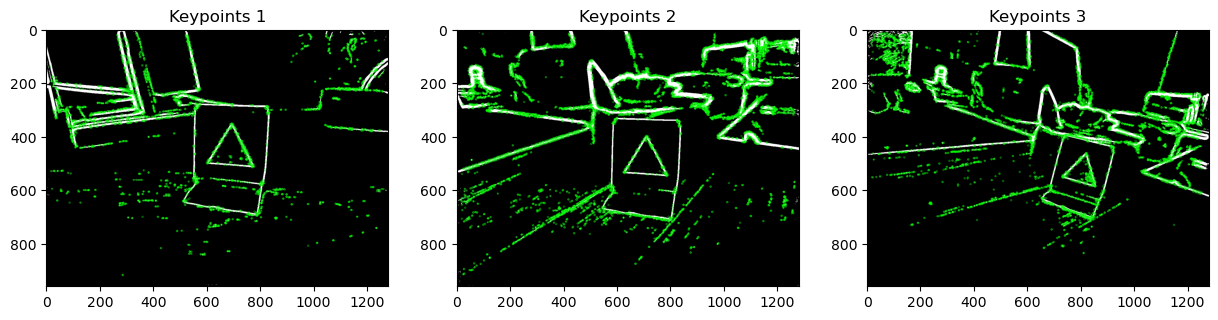

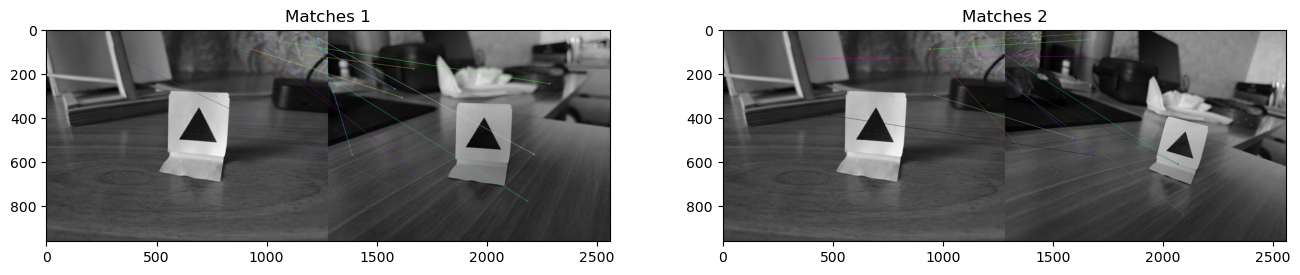

In [44]:
# brisk
brisk = cv2.BRISK_create(thresh=50)  # Можно настроить параметры для изменения количества ключевых точек

keypoints1, descriptors1 = brisk.detectAndCompute(image_roberts_1_8u, None)
keypoints2, descriptors2 = brisk.detectAndCompute(image_roberts_2_8u, None)
keypoints3, descriptors3 = brisk.detectAndCompute(image_roberts_3_8u, None)

output_image1 = cv2.drawKeypoints(image_roberts_1_8u, keypoints1, None, color=(0, 255, 0))
output_image2 = cv2.drawKeypoints(image_roberts_2_8u, keypoints2, None, color=(0, 255, 0))
output_image3 = cv2.drawKeypoints(image_roberts_3_8u, keypoints3, None, color=(0, 255, 0))

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1), plt.imshow(output_image1), plt.title('Keypoints 1')
plt.subplot(1, 3, 2), plt.imshow(output_image2), plt.title('Keypoints 2')
plt.subplot(1, 3, 3), plt.imshow(output_image3), plt.title('Keypoints 3')
plt.show()

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 

matches = bf.match(descriptors1, descriptors2)
matches2 = bf.match(descriptors1, descriptors3)

matches = sorted(matches, key=lambda x: x.distance)
matches2 = sorted(matches2, key=lambda x: x.distance)

result_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
result_image2 = cv2.drawMatches(image1, keypoints1, image3, keypoints3, matches2[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1), plt.imshow(result_image), plt.title('Matches 1')
plt.subplot(1, 2, 2), plt.imshow(result_image2), plt.title('Matches 2')
plt.show()


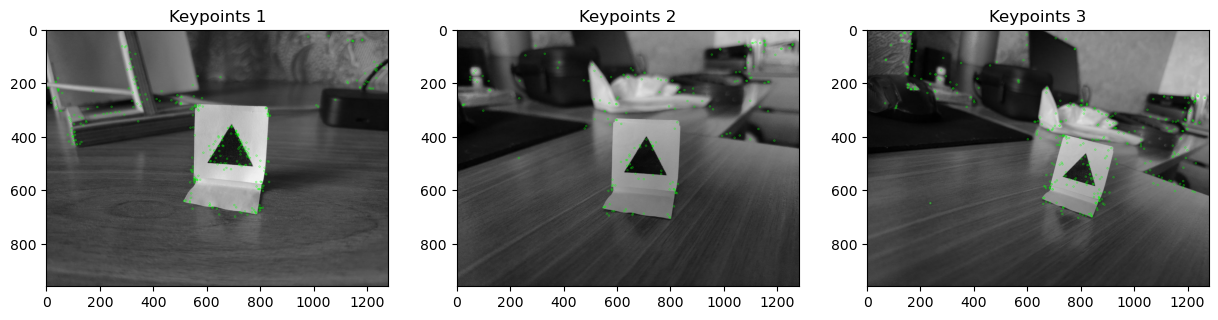

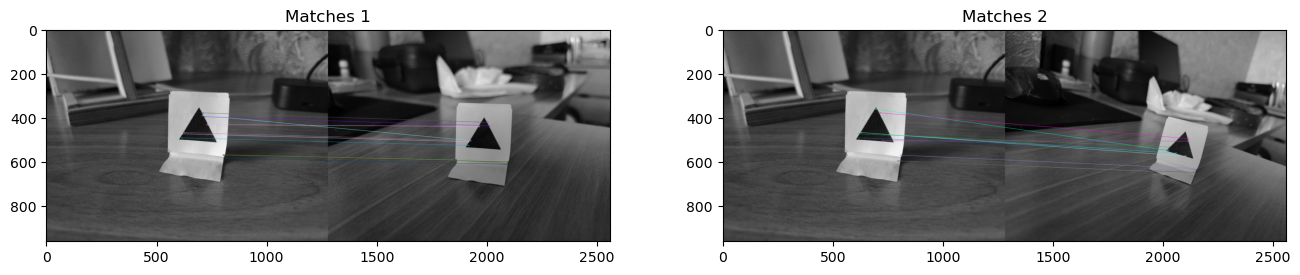

In [45]:
# Kaze
kaze = cv2.KAZE_create()

keypoints1, descriptors1 = kaze.detectAndCompute(image1, None)
keypoints2, descriptors2 = kaze.detectAndCompute(image2, None)
keypoints3, descriptors3 = kaze.detectAndCompute(image3, None)

output_image1 = cv2.drawKeypoints(image1, keypoints1, None, color=(0, 255, 0))
output_image2 = cv2.drawKeypoints(image2, keypoints2, None, color=(0, 255, 0))
output_image3 = cv2.drawKeypoints(image3, keypoints3, None, color=(0, 255, 0))

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1), plt.imshow(output_image1, cmap='gray'), plt.title('Keypoints 1')
plt.subplot(1, 3, 2), plt.imshow(output_image2, cmap='gray'), plt.title('Keypoints 2')
plt.subplot(1, 3, 3), plt.imshow(output_image3, cmap='gray'), plt.title('Keypoints 3')
plt.show()

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches1 = bf.match(descriptors1, descriptors2)
matches2 = bf.match(descriptors1, descriptors3)

matches1 = sorted(matches1, key=lambda x: x.distance)
matches2 = sorted(matches2, key=lambda x: x.distance)

result_image1 = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches1[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
result_image2 = cv2.drawMatches(image1, keypoints1, image3, keypoints3, matches2[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1), plt.imshow(result_image1), plt.title('Matches 1')
plt.subplot(1, 2, 2), plt.imshow(result_image2), plt.title('Matches 2')
plt.show()